## Import libraries

In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import dsa
from dsa import *
from models import mlp
import pickle
from sklearn.model_selection import train_test_split

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

aux_target_ratio = 0.2

xy = np.loadtxt("../datasets/wine-white.csv", delimiter=";")
np.random.shuffle(xy)
x = xy[:,0:-1]
y = xy[:,-1]-3

x = (x-np.min(x, axis=0))/(np.max(x, axis=0) - np.min(x, axis=0))
y = y.reshape((len(x), 1)).astype("float32")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=aux_target_ratio/(aux_target_ratio+1), random_state=42)

target_ds = make_dataset(x_train, y_train, lambda t: t)
aux_ds = make_dataset(x_test, y_test, lambda t: t)

In [4]:
wine_dsa = {}
log_wine_dsa = {}

for split in [4,3,2]:
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=11, class_num=7, split=split, units=64, ed_act="relu")
    wine_dsa[split] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    log_wine_dsa[split] = wine_dsa[split].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
        acc_fn=tf.keras.metrics.SparseCategoricalAccuracy(),
        batch_size=32,
        iterations=10000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.00001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.00001,
        lr_c=0.0001,
        verbose=True,
        log_freq=500)

======Split level is 4======
Iteration 500, train accuracy: 0.4795703790485859, average attack MSE: 0.09949478296935559
Iteration 1000, train accuracy: 0.5172848894596099, average attack MSE: 0.08156318315863609
Iteration 1500, train accuracy: 0.5271710419654846, average attack MSE: 0.06229284057021141
Iteration 2000, train accuracy: 0.5337143797874451, average attack MSE: 0.04959587924182415
Iteration 2500, train accuracy: 0.5393949643373489, average attack MSE: 0.03928160728514195
Iteration 3000, train accuracy: 0.5438229175806045, average attack MSE: 0.03284634493291378
Iteration 3500, train accuracy: 0.5475053303241729, average attack MSE: 0.029094327822327615
Iteration 4000, train accuracy: 0.550326247215271, average attack MSE: 0.026468797005712984
Iteration 4500, train accuracy: 0.552798776268959, average attack MSE: 0.025210514299571513
Iteration 5000, train accuracy: 0.5554720064401627, average attack MSE: 0.02418163537234068
Iteration 5500, train accuracy: 0.5580018547773361,

In [10]:
from fsha import *

wine_fsha={}
log_wine_fsha={}

for split in [4,3,2]:
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    hparams = {
        'WGAN' : False,
        'style_loss' : None,
        'lr_f' :  0.001,
        'lr_tilde': 0.001,
        'lr_D': 0.001,
        'lr_g': 0.001
    }
    make_f, make_g, make_e, make_d, make_c = mlp.make_mlp_fsha(attr_num=11, class_num=7, split=split, units=64, ed_act=None)
    models = (make_f, make_g, make_e, make_d, make_c)
    wine_fsha[split] = FSHA(
        target_ds, aux_ds,
        loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
        acc_fn=tf.keras.metrics.SparseCategoricalAccuracy(), models=models, batch_size=32, hparams=hparams)
    log_wine_fsha[split]=wine_fsha[split](10000, verbose=True, progress_bar=False, log_frequency=1000)

======Split level is 4======
RUNNING...
Iteration 0000000 train accuracy: 0.0625, validation: 0.0954
Iteration 0001000 train accuracy: 0.3945, validation: 0.0352
Iteration 0002000 train accuracy: 0.4307, validation: 0.0345
Iteration 0003000 train accuracy: 0.4382, validation: 0.0819
Iteration 0004000 train accuracy: 0.4406, validation: 0.0420
Iteration 0005000 train accuracy: 0.4433, validation: 0.0178
Iteration 0006000 train accuracy: 0.4451, validation: 0.0126
Iteration 0007000 train accuracy: 0.4464, validation: 0.0121
Iteration 0008000 train accuracy: 0.4474, validation: 0.0120
Iteration 0009000 train accuracy: 0.4481, validation: 0.0119
======Split level is 3======
RUNNING...
Iteration 0000000 train accuracy: 0.3750, validation: 0.0884
Iteration 0001000 train accuracy: 0.4499, validation: 0.0427
Iteration 0002000 train accuracy: 0.4514, validation: 0.0726
Iteration 0003000 train accuracy: 0.4508, validation: 0.0190
Iteration 0004000 train accuracy: 0.4516, validation: 0.0200
Itera

In [11]:
with open('log/wine-dsa.pkl', 'wb') as f:
    pickle.dump(log_wine_dsa, f)
with open('log/wine-fsha.pkl', 'wb') as f:
    pickle.dump(log_wine_fsha, f)

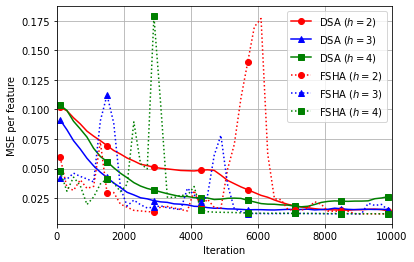

In [12]:
from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 200
# plt.yscale('logit')
plt.xlim([0,10000])
plt.grid()

sampled_loss = {}
sampled_fsha_loss = {}

for split in [2,3,4]:
    sampled_loss[split] = [sum(log_wine_dsa[split][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_wine_dsa[split][:,0])/log_freq))]
    sampled_fsha_loss[split] = [sum(log_wine_fsha[split][:,2][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_wine_fsha[split][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(10000/log_freq))]
plt.ylabel('MSE per feature')
plt.xlabel('Iteration')
plt.plot(ran, sampled_loss[2], 'ro-', ran, sampled_loss[3], 'b^-', ran, sampled_loss[4], 'gs-', markevery=7)
plt.plot(ran, sampled_fsha_loss[2], 'ro:', ran, sampled_fsha_loss[3], 'b^:', ran, sampled_fsha_loss[4], 'gs:', markevery=7)
# ax2=plt.gca().twinx()
# ax2.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.legend(["DSA ($h=2$)", "DSA ($h=3$)", "DSA ($h=4$)", "FSHA ($h=2$)", "FSHA ($h=3$)", "FSHA ($h=4$)"])
plt.savefig("fig/wine.pdf", bbox_inches='tight')

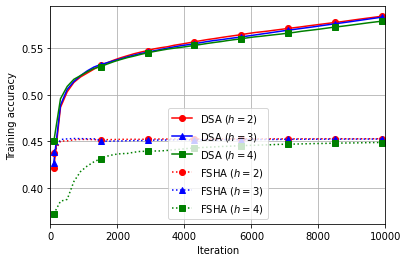

In [14]:
from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 200
# plt.yscale('logit')
plt.xlim([0,10000])
plt.grid()

sampled_acc = {}
sampled_fsha_acc = {}

for split in [2,3,4]:
    sampled_acc[split] = [sum(log_wine_dsa[split][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_wine_dsa[split][:,0])/log_freq))]
    sampled_fsha_acc[split] = [sum(log_wine_fsha[split][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log_wine_fsha[split][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(10000/log_freq))]
plt.ylabel('Training accuracy')
plt.xlabel('Iteration')
plt.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.plot(ran, sampled_fsha_acc[2], 'ro:', ran, sampled_fsha_acc[3], 'b^:', ran, sampled_fsha_acc[4], 'gs:', markevery=7)
# ax2=plt.gca().twinx()
# ax2.plot(ran, sampled_acc[2], 'ro-', ran, sampled_acc[3], 'b^-', ran, sampled_acc[4], 'gs-', markevery=7)
plt.ylabel('Training accuracy')
plt.legend(["DSA ($h=2$)", "DSA ($h=3$)", "DSA ($h=4$)", "FSHA ($h=2$)", "FSHA ($h=3$)", "FSHA ($h=4$)"])
plt.savefig("fig/wine-acc.pdf", bbox_inches='tight')

In [15]:
split=4
wine_dsa_size = {}
log_wine_dsa_size = {}

make_f, make_g, make_e, make_d, make_c = mlp.make_mlp(attr_num=11, class_num=7, split=split, units=64, ed_act="sigmoid")

for size in [1,5,10,20,50]:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size, random_state=42)
    
    target_ds = make_dataset(x_train, y_train, lambda t: t)
    aux_ds = make_dataset(x_test, y_test, lambda t: t)
    
    wine_dsa_size[size] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Auxiliary size is {}======".format(size))
    print("============================")
    log_wine_dsa_size[size] = wine_dsa_size[size].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
        acc_fn=tf.keras.metrics.SparseCategoricalAccuracy(),
        batch_size=32,
        iterations=1000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.001, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.001,
        lr_c=0.001,
        verbose=True,
        log_freq=200)

======Auxiliary size is 1======
Iteration 200, train accuracy: 0.43831575371325016, average attack MSE: 0.030312098935246466
Iteration 400, train accuracy: 0.4859180136024952, average attack MSE: 0.020742380572482944
Iteration 600, train accuracy: 0.5017779412865638, average attack MSE: 0.021065854765474797
Iteration 800, train accuracy: 0.5116744583845139, average attack MSE: 0.02090949532110244
Iteration 1000, train accuracy: 0.5167974761128425, average attack MSE: 0.021235131425783038
======Auxiliary size is 5======
Iteration 200, train accuracy: 0.41981628455221653, average attack MSE: 0.021938691134564578
Iteration 400, train accuracy: 0.48085480570793154, average attack MSE: 0.012314588259905578
Iteration 600, train accuracy: 0.49784431874752044, average attack MSE: 0.012228964478708804
Iteration 800, train accuracy: 0.5059492745995522, average attack MSE: 0.012285072742961346
Iteration 1000, train accuracy: 0.5123057687282562, average attack MSE: 0.012394494614563883
======Auxil

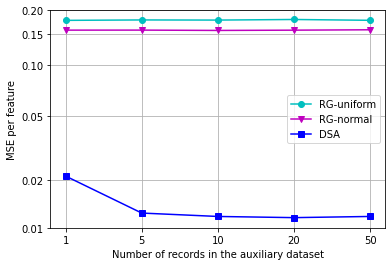

In [27]:
ran = ["1","5","10","20","50"]
rgn = [tf.keras.losses.MeanSquaredError()(np.random.normal(loc=0.5,scale=0.25,size=x.shape),x) for i in ran]
rgu = [tf.keras.losses.MeanSquaredError()(np.random.uniform(low=0,high=1,size=x.shape),x) for i in ran]
mse = [0.0212,0.0124,0.0118,0.0116,0.0118]
plt.yscale('logit')
plt.ylim([0.01,0.20])
plt.grid()
plt.yticks(ticks=[0.01,0.02,0.05,0.1,0.15,0.2],labels=["0.01","0.02","0.05","0.10","0.15","0.20"])
plt.plot(ran,rgu,'co-',ran,rgn,'mv-',ran,mse,'bs-', markevery=1)
plt.ylabel('MSE per feature')
plt.xlabel('Number of records in the auxiliary dataset')
plt.legend(["RG-uniform", "RG-normal", "DSA"])
plt.savefig("fig/wine-size.pdf", bbox_inches='tight')

Seems all right!